In [16]:
import json

import numpy as np
import scipy.io.wavfile as wav
from typing import Iterable
import librosa
from matplotlib import pyplot as plt

In [17]:
import itertools

class wave:
    def __init__(self, wave, frequency: list[int], sr):
        self.sr = sr
        self.wave = wave
        self.frequency = frequency
        self.text_description = None

    def hann(self, window_size: int):
        return np.hanning(window_size)

    def concat(self, wavelist: Iterable, order: Iterable):
        window = self.hann(0.4 * self.sr)
        for i in range(len(wavelist)):
            index = math.floor(0.2 * self.sr)
            order_index = order[i]
            if order_index!= 0:
                wavelist[i].wave[:index] = wavelist[i].wave[:index] * window[:index]
            if order_index != len(order) - 1:
                wavelist[i].wave[-index:] = wavelist[i].wave[-index:] * window[index:]
        sorted_list = sorted(wavelist, key=lambda i: order[wavelist.index(i)])
        newwave = np.concatenate([e.wave for e in sorted_list])
        frequency_list = [w.frequency for w in sorted_list]
        frequencies = list(itertools.chain.from_iterable(frequency_list))
        return wave(newwave, frequencies, sr=self.sr)

    def superimpose(self, wavelist):
        container = np.zeros_like(wavelist[0].wave, dtype=np.float64)
        for i in range(len(wavelist)):
            container += wavelist[i].wave
        return wave(container, wavelist[0].frequency, sr=self.sr)

    def energy_scale_linear(self, scale_factor):
        assert scale_factor > 0, "scale factor must be a positive number"
        scale = np.linspace(1, scale_factor, self.wave.shape[0])
        return self.wave * scale

    def displayspectrogram(self, spectrogram: np.ndarray):
        librosa.display.specshow(spectrogram, sr=self.sr, y_axis='mel', hop_length=512, fmax=8820, x_axis='time')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show()  # 显示图表

    def spectrogram(self):
        mel_spect = librosa.feature.melspectrogram(y=self.wave, sr=self.sr, hop_length=512, window='hann', n_mels=128)
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
        return mel_spect

    def plot_waveform(self):
        time = np.arange(0, len(self.wave)) * (1.0 / self.sr)
        plt.figure(figsize=(10, 4))  # 设置图形的尺寸
        plt.plot(time, self.wave)  # 绘制波形图
        plt.xlabel('Time')  # X轴标签
        plt.ylabel('Amplitude')  # Y轴标签
        plt.title('Waveform')  # 图表标题
        plt.grid(True)  # 显示网格
        plt.show()  # 显示图表

    def save(self, filename: str):
        wav.write(filename, self.sr, self.wave.astype(np.float32))


    def load(self, filename: str, text):
        sr, data = wav.read(filename)
        self.sr = sr
        self.wave = data
        self.text_description = text
        numbers = re.findall(r'\d+', text)
        self.frequency = numbers


In [18]:
from numpy import log
from numpy import asarray, pi
from scipy.signal import square, sawtooth


class WaveGenerator():
    def __init__(self, samplerate):
        self.sr = samplerate
        self.period = 2 * pi

    def sawtooth(self, x, phase=None):
        if phase is not None:
            phase_offset = phase
        else:
            phase_offset = 0
        return 2 * ((x + phase_offset) / self.period - np.floor(0.5 + (x + phase_offset) / self.period))

    def Triangle(self, x, phase=None):
        if phase is not None:
            phase_offset = phase
        else:
            phase_offset = 0

        x = (x + phase_offset) % self.period
        if x <= self.period / 4:
            y = (4 / self.period) * x
        elif x > self.period / 4 and x <= self.period * 3 / 4:
            y = 2 - (4 / self.period) * x
        else:
            y = -4 + (4 / self.period) * x
        return y

    def square(self, x, phase=None):
        if phase is not None:
            phase_offset = phase
        else:
            phase_offset = 0
        return np.sign(np.sin(x + phase_offset))

    def sin(self, x, phase=None):
        if phase is not None:
            phase_offset = phase
        else:
            phase_offset = 0
        return np.sin(x + phase_offset)

    def cons(self, *args):
        return 1

    def generatePerWav(self, function, frequency, amplitude, duration, phase=None):
        if function == 'sin':
            waveform = self.sin
        elif function == 'square':
            waveform = self.square
        elif function == "sawtooth":
            waveform = self.sawtooth
        elif function == "triangle":
            waveform = self.Triangle
        elif function == "cons":
            waveform = self.cons
        else:
            raise ValueError("please input a valid function name")

        wavetable_length = 25600
        wavetable = np.zeros(wavetable_length)
        output = np.zeros((duration * self.sr))
        index = 0
        index_increment = frequency * wavetable_length / self.sr

        for n in range(wavetable_length):
            wavetable[n] = waveform(2 * np.pi * n / wavetable_length, phase) * amplitude

        for n in range(output.shape[0]):
            output[n] = self.interpolate_linearly(wavetable, index)
            index += index_increment
            index %= wavetable_length
        return output

    def interpolate_linearly(self, wavetable, indx):
        i = int(np.floor(indx))
        next_i = (i + 1) % wavetable.shape[0]
        left_weight = indx - i
        right_weight = 1 - left_weight

        return left_weight * wavetable[i] + right_weight * wavetable[next_i]

    def generatechirp(self, wavetype, t, f0, f1, t1, method, amplitude=1, phase=0):
        de = self.chirp_phase(t, f0, f1, t1, method)
        phase = phase * pi / 180
        if wavetype == "sin":
            return amplitude * np.sin(de + phase)
        elif wavetype == "sawtooth":
            return amplitude * sawtooth(de + phase)
        elif wavetype == "square":
            return amplitude * square(de + phase)
        else:
            return None

    def chirp_phase(self, t, f0, f1, t1, method='linear', vertex_zero=True):
        """
        Calculate the phase used by `chirp` to generate its output.

        See `chirp` for a description of the arguments.
        """
        t = asarray(t)
        f0 = float(f0)
        t1 = float(t1)
        f1 = float(f1)

        if method in ['linear', 'lin', 'li']:
            beta = (f1 - f0) / t1
            phase = 2 * pi * (f0 * t + 0.5 * beta * t * t)

        elif method in ['quadratic', 'quad', 'q']:
            beta = (f1 - f0) / (t1 ** 2)
            if vertex_zero:
                phase = 2 * pi * (f0 * t + beta * t ** 3 / 3)
            else:
                phase = 2 * pi * (f1 * t + beta * ((t1 - t) ** 3 - t1 ** 3) / 3)

        elif method in ['logarithmic', 'log', 'lo']:
            if f0 * f1 <= 0.0:
                raise ValueError("For a logarithmic chirp, f0 and f1 must be "
                                 "nonzero and have the same sign.")
            if f0 == f1:
                phase = 2 * pi * f0 * t
            else:
                beta = t1 / log(f1 / f0)
                phase = 2 * pi * beta * f0 * (pow(f1 / f0, t / t1) - 1.0)

        elif method in ['hyperbolic', 'hyp']:
            if f0 == 0 or f1 == 0:
                raise ValueError("For a hyperbolic chirp, f0 and f1 must be "
                                 "nonzero.")
            if f0 == f1:
                # Degenerate case: constant frequency.
                phase = 2 * pi * f0 * t
            else:
                # Singular point: the instantaneous frequency blows up
                # when t == sing.
                sing = -f1 * t1 / (f0 - f1)
                phase = 2 * pi * (-sing * f0) * log(np.abs(1 - t / sing))
        else:
            raise ValueError("method must be 'linear', 'quadratic', 'logarithmic',"
                             " or 'hyperbolic', but a value of %r was given."
                             % method)
        return phase

    def generateComposition(self, type, functions: list, frequency, amplitude: list, duration, phase, **kwargs):
        assert len(functions) == len(amplitude), "the length of functions and amplitude must be same"
        assert len(functions) <= 3 and len(functions) >= 1, "Compound 3 wave clips at most"
        wavedict = dict()
        for i in range(len(functions)):
            wavedict[i] = self.generate(type, functions[i], frequency, amplitude[i], duration, phase, **kwargs)
        newwave = wavedict[0].superimpose(list(wavedict.values()))
        return newwave

    def generate(self, type, functions, frequency: list, amplitude, duration, phase, **kwargs):
        if type == "chirp":
            method = kwargs["method"]
            if functions in ["sin", "sawtooth", "square"]:
                if len(frequency) != 2:
                    raise ValueError("The tuple should contain at least 2 numbers for frequency.")
                else:
                    t = np.linspace(0, duration, self.sr * duration)
                    wavedata = self.generatechirp(functions, t, frequency[0], frequency[1], duration, method, amplitude,
                                                  phase)
                    clip = wave(wavedata, frequency, self.sr)
            else:
                raise ValueError("function must be 'sin', 'sawtooth', 'square'")

        else:
            ## generate normal periodical wave clip
            wavedata = self.generatePerWav(functions, frequency[0], amplitude, duration, phase)
            clip = wave(wavedata, list(frequency), self.sr)
        return clip


In [19]:
class Aperiodic_wave():

    def triangle_pulse(self, cons_am, climax_am, duration, start_time, end_time, samplerate): 
        t = np.linspace(0, duration, int(samplerate * duration))
        waveform = np.full(t.shape, cons_am,dtype=np.float32)
        start_sample = int(start_time * samplerate)
        end_sample = int(end_time * samplerate)
        climax_point = int(np.floor((start_sample + end_sample)/2))
        waveform[start_sample:climax_point] = np.linspace(waveform[start_sample], climax_am, climax_point - start_sample)
        waveform[climax_point:end_sample] = np.linspace(climax_am, cons_am, end_sample - climax_point )
        print(waveform.dtype)
        return waveform

    def square_pulse(self, cons_am, climax_am, duration, start_time, end_time, samplerate): 
        t = np.linspace(0, duration, int(samplerate * duration))
        waveform = np.full(t.shape, cons_am,dtype=np.float32)
        start_sample = int(start_time * samplerate)
        end_sample = int(end_time * samplerate)
        waveform[start_sample:end_sample] = climax_am
        return waveform
    
    def step_pulse(self, low_am, high_am, duration, change_time, samplerate):
        t = np.linspace(0, duration, int(samplerate * duration))
        waveform = np.zeros_like(t)
        change_sample = int(change_time * samplerate)
        waveform[0:change_sample] = low_am
        waveform[change_sample:] = high_am
        return waveform
        
    def generateWav(self,function, f_am, s_am, duration, start_time, end_time , sampleRate = 8820):
        '''
        this function is used to generate aperiodic waveform
        :param function: parametrized function, triangle, square and step
        :param f_am: if function = triangle or square, it stands for which amplitude the waveform in when not in the inpulse time, otherwise it stands for low amplitude that step wave has
        :param s_am: if function = triangle or square, it stands for which amplitude the waveform in when in the inpulse time, otherwise it stands for high amplitude that step wave has
        :param start_time: if function = triangle or square, it stands for the time that inpulse happens, otherwise it stands for
        the time that step happens
        :param end_time: step wave do not use this.
        '''
        
        assert end_time >= start_time, "end time must be larger than start time"
        assert end_time < duration, "end time must be smaller than duration"

        if function == 'square':
            waveform = self.square_pulse(f_am, s_am, duration, start_time, end_time, sampleRate)
        elif function == "triangle":
            waveform = self.triangle_pulse(f_am, s_am, duration, start_time, end_time,  sampleRate)
        elif function == "step":
            waveform = self.step_pulse(low_am = f_am, high_am = s_am, duration = duration, change_time = start_time, samplerate = sampleRate )
        else:
            raise ValueError("please input a valid function name")
        
        return waveform


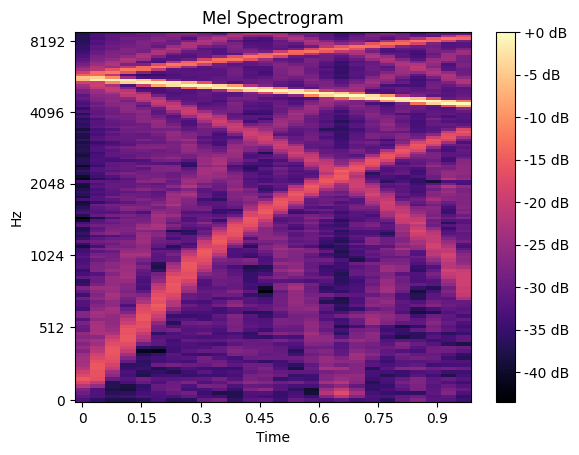

In [20]:
generator = WaveGenerator(13230)
wave_1 = generator.generateComposition("chirp",["sin","sawtooth", "sin"],[4373, 3468],[58, 87, 88],1, 193,method ="linear")
# wave_2 = generator.generate("chirp","sawtooth",(40,20),10, 5, 0, method = "hyperbolic")
# wave_4 = generator.generate("Tone", "square", 100,20, 3, phase=0)
# wave_3 = wave_1.superimpose([wave_1,wave_2])
# wave_5 = wave_1.concat([wave_4,wave_3],[1,0])
s = wave_1.spectrogram()
wave_1.displayspectrogram(s)

# wave_1.plot_waveform()

In [7]:
with open("template.json","r") as f:
    t = json.load(f)

seed = np.random.seed(0)


class TextTemplate():
    def __init__(self, template, seed):
        self.template = template
        self.seed = seed
        
    def generatetext(self, w: wave):
        frequency_l = len(w.frequency)
        trend = self.checktrend(w.frequency)
        print(trend)
        if frequency_l == 1:
            trend = "1"
            t_len = len(self.template[trend])
            pick = self.generateint(t_len)
            text = self.template[trend][pick].format(*w.frequency)
            
        else:
            if frequency_l > 4:
                raise ValueError("The maximum length of frequency is 4")
            else:
                t_len = len(self.template["{}".format(frequency_l)][trend])
                pick = self.generateint(t_len)
                text = self.template["{}".format(frequency_l)][trend][pick].format(*w.frequency)
        return text
            
            
    def generateint(self, t_len):
        return np.random.randint(0,t_len)
    
    def checktrend(self, frequencies: list):
        trend = ""
        for i in range(len(frequencies)-1):
            if frequencies[i] < frequencies[i+1]:
                trend +="u"
            else:
                trend +="d"
        return trend

In [32]:
template = TextTemplate(t, seed)
text = template.generatetext(wave_5)
text

dud


'The frequency of the audio file dropped from 10 Hz to 2 Hz, went up to 200 Hz, and then decreased to 100 Hz.'

In [21]:
a = np.random.randint(0, 4,size = (2))
tuple(a)


(0, 1)

In [1]:
import math

# 给定的频率
frequency_hz = 2046

# 转换为 Mel 频率
mel_frequency = 2595 * math.log2(1 + frequency_hz / 700)

mel_frequency

5117.092951626833

In [33]:
import re

def extract_numbers(input_string):
    # 使用正则表达式查找所有数字
    numbers = re.findall(r'\d+', input_string)
    # 将找到的数字转换为整数

    return numbers

# 示例字符串
input_string = "There are 2 apples, 5 oranges, and 10 bananas."

# 提取数字
numbers_list = extract_numbers(input_string)

print(type(numbers_list))

<class 'list'>
